### 
A tool ( Python Code, preferably a Python Class / Function ) that can digitise a plot - convert a chart/plot/image to raw data. For simplicity, it can start with a “scatterplot” digitisation.

Here is the expectation - 
The user uploads a well-cropped image of a scatterplot. The user can also provide any other UI based input/inputs such as “origin” if required for the tool. After successful execution of the code, a csv file gets created holding the raw data for columns X and Y of the scatterplot 

### Imports

In [32]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from statistics import mode
import math
import csv
import pandas as pd

Algorithms used :

1. Canny
2. HoughLinesP

In [72]:
# Class for generating the coordinate points.
class PredictPoints:
    x_cod=[]
    y_cod=[]
    
    def __init__(self,path,x_min,x_max,y_min,y_max):
        self.path=path
        self.new_max_x=x_max
        self.new_min_x=x_min
        self.new_max_y=y_max
        self.new_min_y=y_min
                
    def original_value(self,old_max,old_min,new_max,new_min,old_value):
        old_range = (old_max - old_min)  
        new_range = (new_max - new_min)  
        new_value = round(((((old_value - old_min) * new_range) / old_range) + new_min),2)
        return new_value

    # This method is used to scale the coordinate points according the input value range
    def generate_scaled_point(self):
        for i in range(len(self.x_cod)):
            self.x_cod[i]=self.original_value(1000,0,self.new_max_x,self.new_min_x,self.x_cod[i])
            self.y_cod[i]=self.original_value(1000,0,self.new_max_y,self.new_min_y,self.y_cod[i])
            
    # This method generates the corordinates of the x-axis and y-axis.
    # Hence allowing us to shift our base lines(x,y axis) from the boundary of the image 
    # to some certain x,y axis equivalent inside the image.

    def generate_lines(self):
        image = cv2.imread(self.path)
        gray = cv2.flip(image, 0)
        edges = cv2.Canny(gray,50,150,apertureSize = 3)
        cv2.imwrite('edges.jpg',edges)
        minLineLength=100
        lines = cv2.HoughLinesP(image=edges,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=minLineLength,maxLineGap=80)

        a,b,c = lines.shape
        max_val=[]
        for i in range(a):
            max_val.append(lines[i][0][0])
            max_val.append(lines[i][0][1])
            max_val.append(lines[i][0][2])
            max_val.append(lines[i][0][3])
            print('x1:',lines[i][0][0],'y1:', lines[i][0][1],'x2:',lines[i][0][2],'y2: ',lines[i][0][3])

            cv2.line(gray, (lines[i][0][0], lines[i][0][1]), (lines[i][0][2], lines[i][0][3]), (0, 0, 255), 3, cv2.LINE_AA)
            cv2.imwrite('houghlines7.jpg',gray)
        for i in range(len(self.x_cod)):
            self.x_cod[i]+=mode(max_val)
            self.y_cod[i]+=mode(max_val)
            
           
        self.generate_scaled_point()
        
    # This method uses opencv to detect the points of a scatter plot and returns the coordinates of the points 
    
    def generating_points(self):
         # Load image
        im = cv2.imread(self.path)
        # Convert to grayscale and threshold
        imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
        gray = cv2.flip(imgray, 0)
        ret,thresh = cv2.threshold(gray,1,255,0)
        # Find contours, draw on image and save
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(im, contours, -1, (0,255,0), 3)
        cv2.imwrite('result.png',gray)

        # Show user what we found
        for cnt in contours:
            (x,y),radius = cv2.minEnclosingCircle(cnt)
            center = (x,y)
            radius = round(radius,2)
            # It was seen that the radious of the points lie between the range of 3.3 to 5 .
            if radius>3 and radius<5:
                          print('Contour: centre {},{}'.format(int(x),int(y)))
                          self.x_cod.append(x) #appending the x coordinate value.
                          self.y_cod.append(y) # appending the y coordinate value.
                    
        self.generate_lines()
  
  # This method is used to generate the csv file 
    def generate_csv(self):
        print(self.x_cod)
        print(self.y_cod)
        header = ['x_label','y_label']
        values=[]
        for i in range(len(self.x_cod)):
            values.append([self.x_cod[i],self.y_cod[i]])  
        with open('predicted_labels.csv', 'w', encoding='UTF8', newline='') as f:
            writer = csv.writer(f)
            # write the header
            writer.writerow(header)
            # write multiple rows
            writer.writerows(values)
            print("CSV file generate successfully!! :)")
            
    # This method is used to display the csv file with the image also.        
    def display_csv(self):
    
        data=pd.read_csv('predicted_labels.csv')
        data.head()
        plt.figure(figsize=(14,6))
        plt.subplot(1,2,1)
        plt.title("Predicted")
        plt.scatter(self.x_cod,self.y_cod)
        plt.subplot(1,2,2)
        plt.title("Original")
        im = cv2.imread(self.path)
        plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.xticks([])  
        plt.yticks([])

Contour: centre 480,371
Contour: centre 700,357
Contour: centre 627,322
Contour: centre 553,301
Contour: centre 334,287
Contour: centre 407,266
Contour: centre 260,217
Contour: centre 114,111
Contour: centre 187,76
x1: 13 y1: 40 x2: 772 y2:  40
x1: 42 y1: 393 x2: 42 y2:  34
x1: 40 y1: 391 x2: 40 y2:  12
[62061.11, 84034.85, 76700.0, 69370.0, 47400.0, 54750.0, 40057.14, 25443.94, 32765.15]
[70.57, 69.87, 68.12, 67.06, 66.37, 65.3, 62.85, 57.58, 55.83]
CSV file generate successfully!! :)


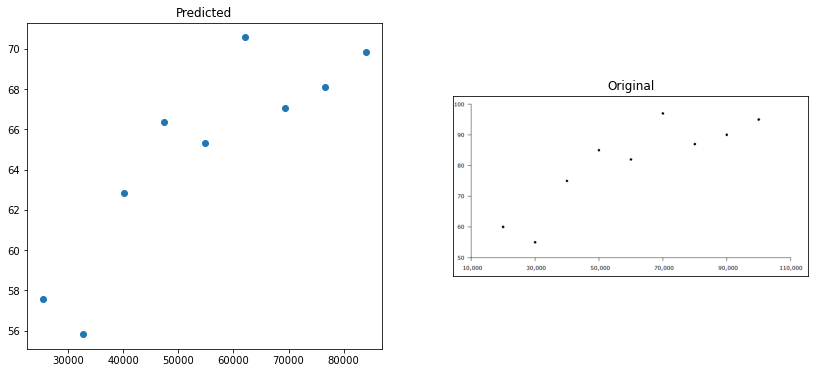

In [73]:
# creating instance of PredictPoint class. 
# This class' constructor takes following arguments: image path, x axis range and y axis range.
# PredictPoints("image path",x_min,x_max,y_min,y_max)

pred=PredictPoints('img12.png',10000,110000,50,100)
pred.generating_points()
pred.generate_csv()
pred.display_csv()

#### Observation:

1. The predicted points may not be the same like the ones given in the input image.

2. This model might not work well for scatter plots that involves points lying in negative quadrents.



#### Referances:
1. OpenCV, Open Source Computer Vision,https://docs.opencv.org/3.4/index.html
2. Stack Overflow, https://stackoverflow.com/

#### Image Resource:
https://www150.statcan.gc.ca/n1/edu/power-pouvoir/c-g/c-g05-6-1-eng.png